# VQE Encoding Comparison

This notebook compares encoding methods using the shared VQE pipeline.
We keep the Hamiltonian, ansatz, optimizer, and budget fixed and only vary the encoding.


In [49]:
import os
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.encodings import BasisEncoding, AngleEncoding, ReuploadingAngleEncoding, AmplitudeEncoding
from src.vqe import DEFAULT_HAMILTONIAN_TERMS, build_hamiltonian, exact_ground_energy, run_vqe


## Experiment constants

In [50]:
n_qubits = 2
layers = 2
maxiter = 200
seeds = [0, 1, 2, 3, 4]

grid_vals = [-1.0, 0.0, 1.0]
inputs = [np.array([x, y], dtype=float) for x in grid_vals for y in grid_vals]

encoders = [
    BasisEncoding(threshold=0.0),
    AngleEncoding(),
    ReuploadingAngleEncoding(reps=3, entangle=True),
    AmplitudeEncoding(fixed_n_qubits=2),
]

results_dir = PROJECT_ROOT / 'results' / 'vqe'
results_dir.mkdir(parents=True, exist_ok=True)


## Build Hamiltonian and compute ground energy once

In [51]:
hamiltonian = build_hamiltonian(DEFAULT_HAMILTONIAN_TERMS, n_qubits=n_qubits)
ground_energy = exact_ground_energy(hamiltonian)
print('Ground energy:', ground_energy)


Ground energy: -1.0376992382090828


## Run VQE for each encoding, input, and seed

In [52]:
out_path = results_dir / "vqe_runs.json"

if out_path.exists():
    with out_path.open("r", encoding="utf-8") as f:
        payload = json.load(f)
    results = payload["results"]
    print("Loaded", out_path, "with", len(results), "runs")
else:
    results = []

    for enc in encoders:
        for seed in seeds:
            for x in inputs:
                res = run_vqe(
                    enc, x, hamiltonian,
                    n_qubits=n_qubits, layers=layers, maxiter=maxiter,
                    seed=seed, ground_energy=ground_energy,
                )
                results.append({
                    "encoding": res.encoding,
                    "seed": res.seed,
                    "x": res.x.tolist(),
                    "energies": res.energies.tolist(),
                    "best_energies": res.best_energies.tolist(),
                    "final_energy": res.final_energy,
                    "final_error": res.final_error,
                })

    with out_path.open("w", encoding="utf-8") as f:
        json.dump({
            "config": {
                "n_qubits": n_qubits,
                "layers": layers,
                "maxiter": maxiter,
                "seeds": seeds,
                "inputs": [x.tolist() for x in inputs],
                "hamiltonian_terms": DEFAULT_HAMILTONIAN_TERMS,
            },
            "results": results,
        }, f, indent=2)

    print("Saved", out_path)

Saved /home/lucas/uni/semester5/fqc/final_project/results/vqe/vqe_runs.json


## Aggregate results per encoding

In [53]:
by_encoding = {}
for r in results:
    by_encoding.setdefault(r['encoding'], []).append(r)

def stack_curves(runs, key, pad_with_last=False):
    curves = [np.asarray(r[key], dtype=float) for r in runs]
    max_len = max(len(c) for c in curves)

    arr = np.zeros((len(curves), max_len), dtype=float)

    for i, c in enumerate(curves):
        arr[i, :len(c)] = c
        if len(c) < max_len:
            if pad_with_last:
                arr[i, len(c):] = c[-1]
            else:
                arr[i, len(c):] = np.nan

    return arr

summary = {}
for enc, runs in by_encoding.items():
    energies = stack_curves(runs, 'energies', pad_with_last=False)
    bests    = stack_curves(runs, 'best_energies', pad_with_last=True)

    finals = np.array([r['final_energy'] for r in runs], dtype=float)
    errors = np.array([r['final_error'] for r in runs], dtype=float)

    summary[enc] = {
        'energies_mean': np.nanmean(energies, axis=0),
        'energies_std':  np.nanstd(energies, axis=0),
        'best_mean': bests.mean(axis=0),
        'best_std':  bests.std(axis=0),
        'final_energy_mean': finals.mean(),
        'final_energy_std':  finals.std(),
        'final_error_mean':  errors.mean(),
        'final_error_std':   errors.std(),
    }

for enc, s in summary.items():
    print(enc, 'final_error mean/std:', s['final_error_mean'], s['final_error_std'])
    assert np.all(np.diff(s['best_mean']) <= 1e-12), f"{enc} best_mean not monotonic"

basis final_error mean/std: 0.0008377090837218739 0.003884275047697411
angle final_error mean/std: 0.0007129492448522543 0.0033583398985881693
angle_reupload final_error mean/std: 0.002134515753204079 0.008925677356021901
amplitude final_error mean/std: 0.0008377095822087553 0.0038842749401946063


## Create Plots for Results

### Plot 1: Energy vs iteration (mean $\pm$ std)

Averages are computed over all runs (all seeds $\times$ all input grid points).

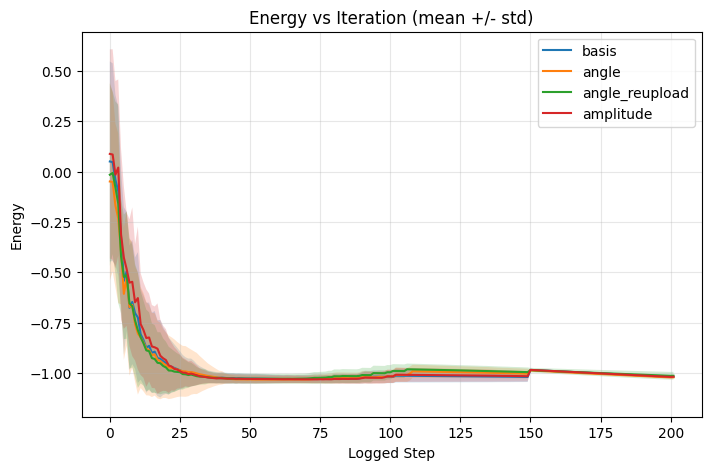

Saved /home/lucas/uni/semester5/fqc/final_project/results/vqe/energy_vs_iter.png


In [54]:
plt.figure(figsize=(8, 5))

for enc, s in summary.items():
    mean = s['energies_mean']
    std = s['energies_std']
    iters = np.arange(len(mean))
    plt.plot(iters, mean, label=enc)
    plt.fill_between(iters, mean - std, mean + std, alpha=0.2)

plt.xlabel('Logged Step')
plt.ylabel('Energy')
plt.title('Energy vs Iteration (mean +/- std)')
plt.legend()
plt.grid(alpha=0.3)

path = results_dir / 'energy_vs_iter.png'
plt.savefig(path, dpi=200, bbox_inches='tight')
plt.show()
print('Saved', path)


### Plot 2: Best-so-far energy vs iteration (mean $\pm$ std)

Averages are computed over all runs (all seeds $\times$ all input grid points).

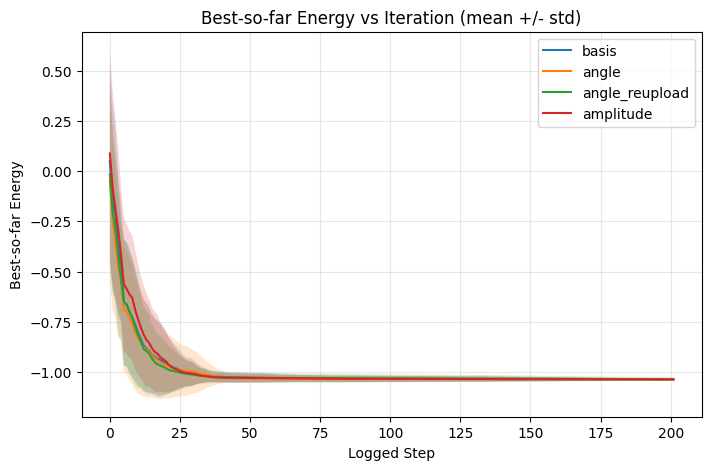

Saved /home/lucas/uni/semester5/fqc/final_project/results/vqe/best_energy_vs_iter.png


In [55]:
plt.figure(figsize=(8, 5))

for enc, s in summary.items():
    mean = s['best_mean']
    std = s['best_std']
    iters = np.arange(len(mean))
    plt.plot(iters, mean, label=enc)
    plt.fill_between(iters, mean - std, mean + std, alpha=0.2)

plt.xlabel('Logged Step')
plt.ylabel('Best-so-far Energy')
plt.title('Best-so-far Energy vs Iteration (mean +/- std)')
plt.legend()
plt.grid(alpha=0.3)

path = results_dir / 'best_energy_vs_iter.png'
plt.savefig(path, dpi=200, bbox_inches='tight')
plt.show()
print('Saved', path)


### Plot 3: Final energy error per encoding (mean $\pm$ std)

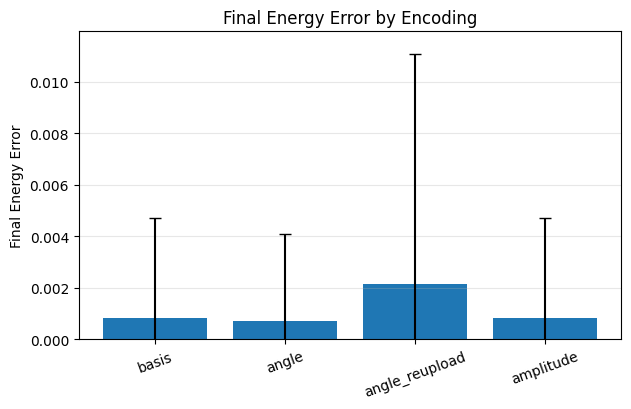

Saved /home/lucas/uni/semester5/fqc/final_project/results/vqe/final_error_bar.png


In [56]:
labels = [enc.name for enc in encoders]
means = [summary[e]["final_error_mean"] for e in labels]
stds  = [summary[e]["final_error_std"]  for e in labels]

plt.figure(figsize=(7, 4))
xpos = np.arange(len(labels))
plt.bar(xpos, means, yerr=stds, capsize=4)
plt.ylim(bottom=0)
plt.xticks(xpos, labels, rotation=20)
plt.ylabel('Final Energy Error')
plt.title('Final Energy Error by Encoding')
plt.grid(axis='y', alpha=0.3)

path = results_dir / 'final_error_bar.png'
plt.savefig(path, dpi=200, bbox_inches='tight')
plt.show()
print('Saved', path)

Global heatmap scale: vmin=0, vmax=0.0113291


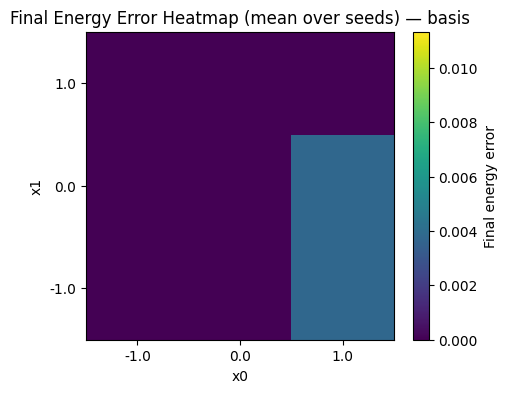

Saved /home/lucas/uni/semester5/fqc/final_project/results/vqe/final_error_heatmap_basis.png


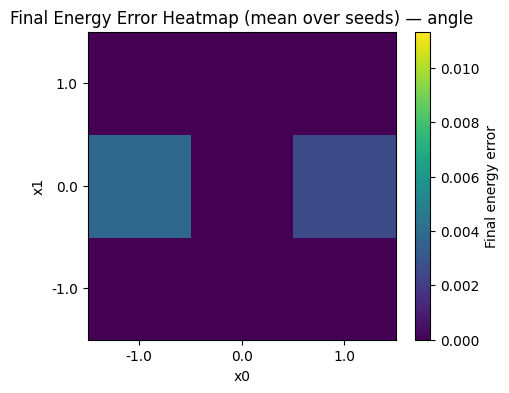

Saved /home/lucas/uni/semester5/fqc/final_project/results/vqe/final_error_heatmap_angle.png


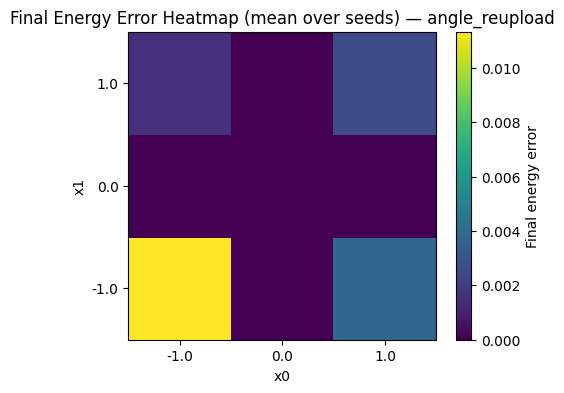

Saved /home/lucas/uni/semester5/fqc/final_project/results/vqe/final_error_heatmap_angle_reupload.png


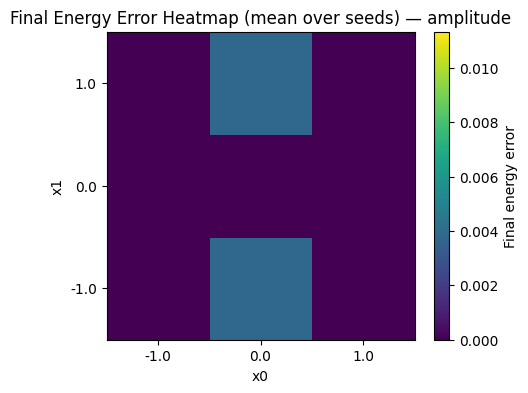

Saved /home/lucas/uni/semester5/fqc/final_project/results/vqe/final_error_heatmap_amplitude.png


In [57]:
# Prepare mapping from x -> grid index
grid_vals = sorted(set(float(x[0]) for x in inputs))  # e.g. [-1, 0, 1]
pos = {v: i for i, v in enumerate(grid_vals)}

# Group errors per encoding and per input point (collect per-seed errors)
errors_by_enc_x = {}
for r in results:
    enc = r["encoding"]
    x0, x1 = map(float, r["x"])
    errors_by_enc_x.setdefault(enc, {}).setdefault((x0, x1), []).append(float(r["final_error"]))

# ---- NEW: compute a global color scale (mean over seeds per grid point, across all encodings) ----
all_mean_errors = []
for enc, grid_dict in errors_by_enc_x.items():
    for (x0, x1), errs in grid_dict.items():
        all_mean_errors.append(float(np.mean(errs)))

global_vmin = 0.0
global_vmax = max(all_mean_errors) if all_mean_errors else 1.0
print(f"Global heatmap scale: vmin={global_vmin:.6g}, vmax={global_vmax:.6g}")

# ---- Plot per encoding using the SAME vmin/vmax ----
for enc in [e.name for e in encoders]:
    if enc not in errors_by_enc_x:
        continue

    heat = np.full((len(grid_vals), len(grid_vals)), np.nan, dtype=float)  # rows=y, cols=x
    for (x0, x1), errs in errors_by_enc_x[enc].items():
        heat[pos[x1], pos[x0]] = float(np.mean(errs))  # y=row, x=col

    plt.figure(figsize=(5, 4))
    im = plt.imshow(
        heat,
        origin="lower",
        vmin=global_vmin,
        vmax=global_vmax,
    )
    plt.xticks(range(len(grid_vals)), grid_vals)
    plt.yticks(range(len(grid_vals)), grid_vals)
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.title(f"Final Energy Error Heatmap (mean over seeds) — {enc}")
    plt.colorbar(im, label="Final energy error")
    plt.grid(False)

    path = results_dir / f"final_error_heatmap_{enc}.png"
    plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved", path)

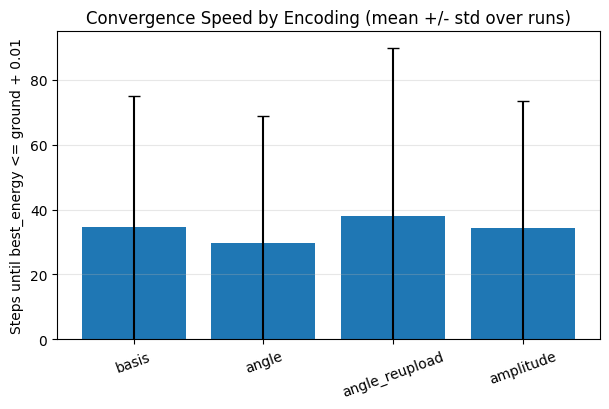

Saved /home/lucas/uni/semester5/fqc/final_project/results/vqe/convergence_speed.png


In [58]:
eps = 1e-2  # pick 1e-3 or 1e-2 depending on how tight you want it
labels = [enc.name for enc in encoders if enc.name in summary]

# For each run: first step where best_energy <= ground + eps
speed = {enc: [] for enc in labels}
for r in results:
    enc = r["encoding"]
    if enc not in speed:
        continue
    best_curve = np.asarray(r["best_energies"], dtype=float)
    idx = np.where(best_curve <= ground_energy + eps)[0]
    speed[enc].append(int(idx[0]) if len(idx) else len(best_curve) - 1)

means = [np.mean(speed[e]) for e in labels]
stds  = [np.std(speed[e])  for e in labels]

plt.figure(figsize=(7, 4))
xpos = np.arange(len(labels))
plt.bar(xpos, means, yerr=stds, capsize=4)
plt.ylim(bottom=0)
plt.xticks(xpos, labels, rotation=20)
plt.ylabel(f"Steps until best_energy <= ground + {eps}")
plt.title("Convergence Speed by Encoding (mean +/- std over runs)")
plt.grid(axis="y", alpha=0.3)

path = results_dir / "convergence_speed.png"
plt.savefig(path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved", path)